# Microproyecto 1 — Clasificación Automática de Tumores Cerebrales para Tipos de Cáncer en Imágenes MRI Mediante Redes Neuronales Convolucionales

**Objetivo:** En este proyecto se busca desarrollar un método basado en redes neuronales convolucionales (CNN) en donde se clasifiquen imágenes 2D extraídas de MRI en las siguientes 4 categorías:

- Glioma
- Meningioma  
- Pituitary
- Sano

Este microproyecto trabaja con **imágenes individuales** (no volúmenes 3D completos) para reducir costo computacional y enfocarse en la tarea de **clasificación**.


## 1. Preparación del Entorno

Instalación de dependencias necesarias.


In [3]:
# Importar librerías necesarias
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import kagglehub
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Crear carpetas necesarias
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)


Dispositivo utilizado: cpu


## 2. Descarga y Organización del Dataset

Descargamos el dataset de Kaggle usando KaggleHub.


In [5]:
# Descargar el dataset
print("Descargando dataset...")
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
print(f"Dataset descargado en: {path}")

# Verificar estructura del dataset
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Mostrar solo los primeros 3 archivos
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... y {len(files) - 3} archivos más')


Descargando dataset...
Dataset descargado en: /Users/breinergonza/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1
1/
  pituitary/
    0071.jpg
    0717.jpg
    1409.jpg
    ... y 1754 archivos más
  healthy/
    0071.jpg
    0717.jpg
    1409.jpg
    ... y 1997 archivos más
  glioma/
    0071.jpg
    0717.jpg
    1409.jpg
    ... y 1618 archivos más
  meningioma/
    0071.jpg
    0717.jpg
    1409.jpg
    ... y 1642 archivos más


### 2.1. Previsualización de Imágenes por Clase

Visualizamos 5 imágenes representativas de cada clase del dataset de manera horizontal.


Carpeta del dataset: /Users/breinergonza/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1
Clases encontradas: ['pituitary', 'healthy', 'glioma', 'meningioma']


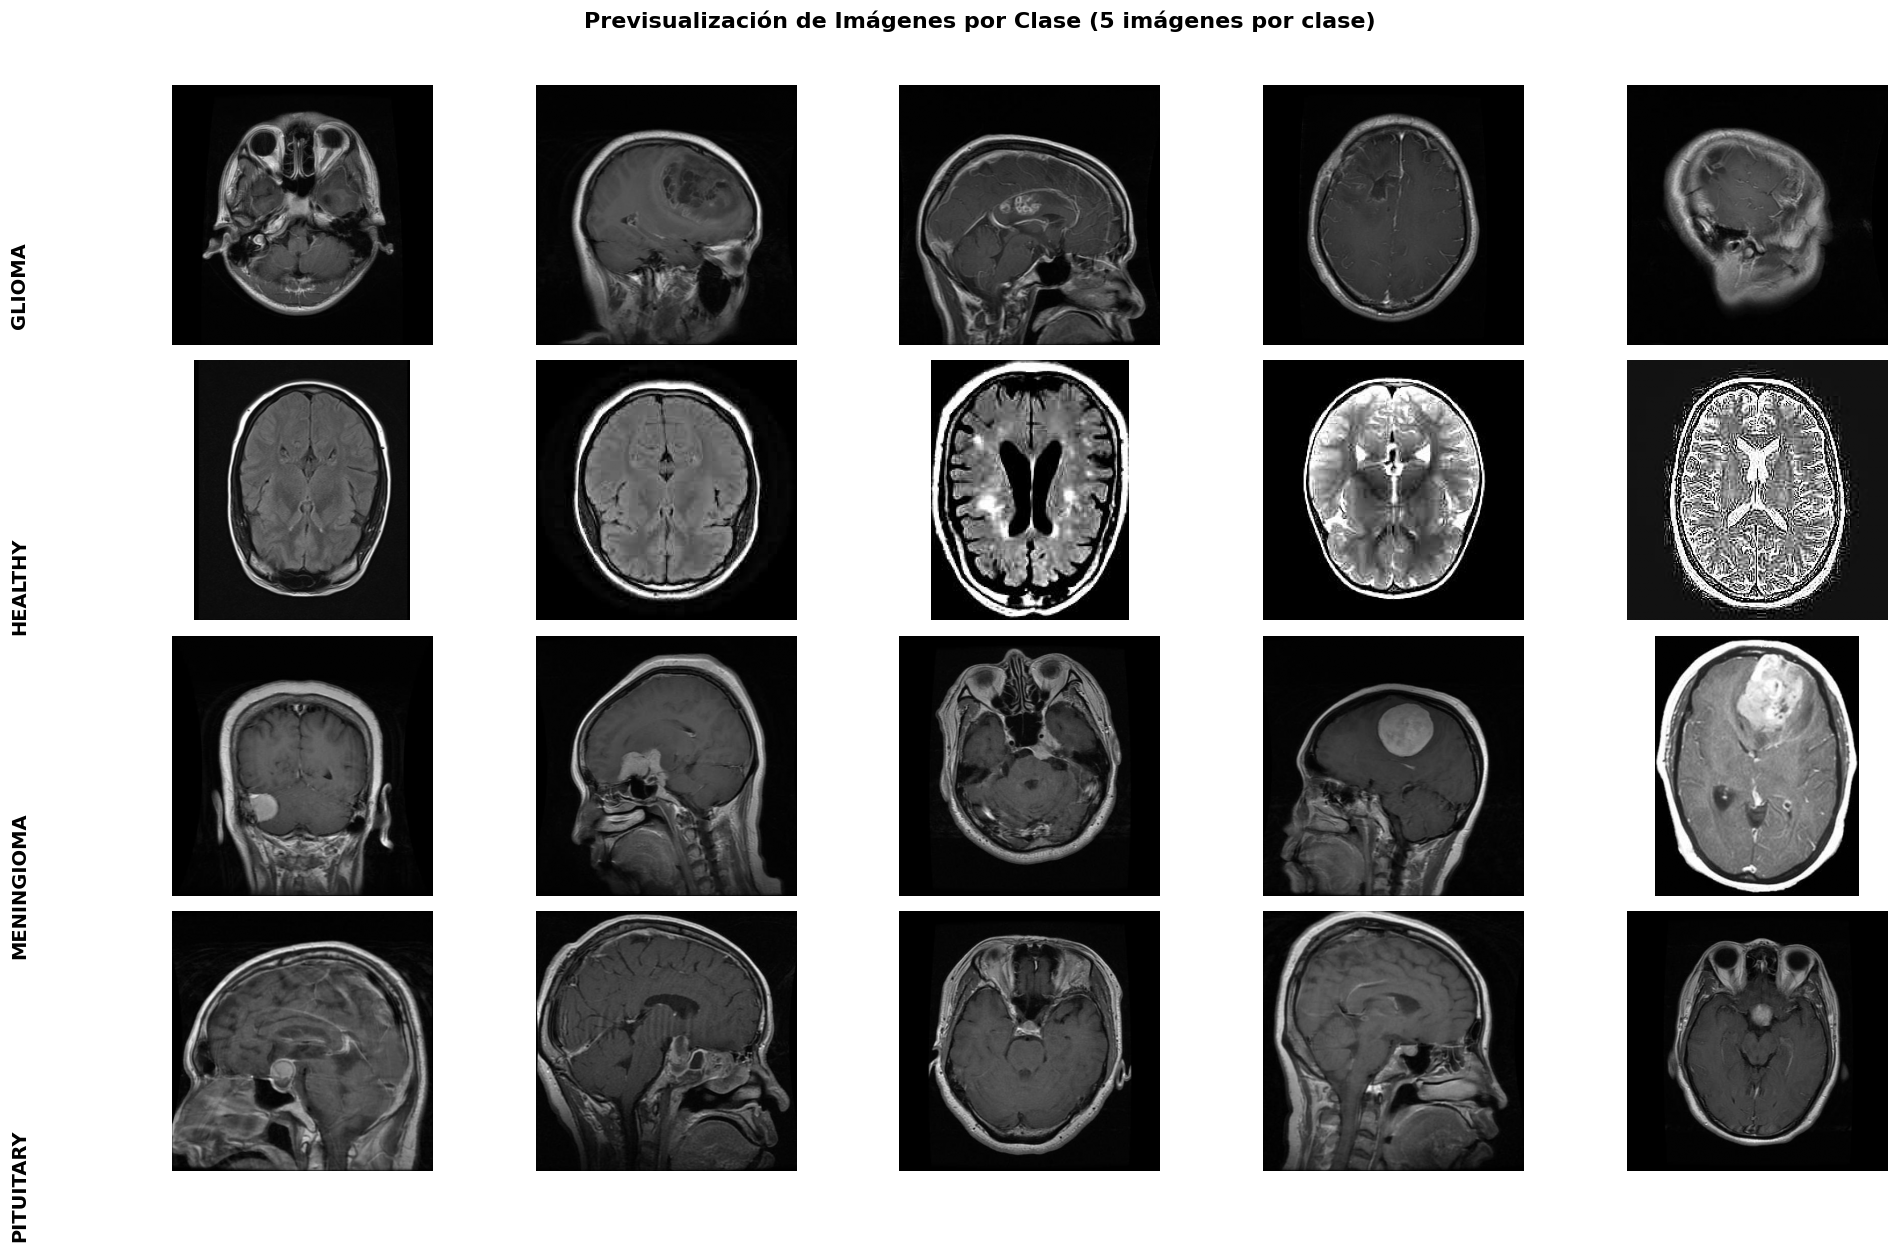

In [7]:
# Previsualizar 5 imágenes de cada clase de manera horizontal
from glob import glob
import random

def preview_images_by_class(dataset_path, class_names=['glioma', 'healthy', 'meningioma', 'pituitary'], num_images=5):
    """
    Visualiza num_images imágenes de cada clase del dataset de manera horizontal
    
    Args:
        dataset_path: Ruta al dataset con subcarpetas por clase
        class_names: Lista de nombres de clases
        num_images: Número de imágenes a mostrar por clase
    """
    
    # Crear figura con 4 filas (una por clase) y num_images columnas (horizontal)
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(20, 12))
    
    if len(class_names) == 1:
        axes = axes.reshape(1, -1)
    
    # Buscar imágenes de cada clase
    for row, class_name in enumerate(class_names):
        # Buscar carpeta de la clase (case-insensitive)
        class_dirs = []
        for item in os.listdir(dataset_path):
            item_path = os.path.join(dataset_path, item)
            if os.path.isdir(item_path):
                # Comparar nombre de carpeta con nombre de clase (case-insensitive)
                if item.lower() == class_name.lower():
                    class_dirs.append(item_path)
                    break
        
        if not class_dirs:
            # Buscar variaciones comunes
            for item in os.listdir(dataset_path):
                item_path = os.path.join(dataset_path, item)
                if os.path.isdir(item_path):
                    if class_name.lower() in item.lower() or item.lower() in class_name.lower():
                        class_dirs.append(item_path)
                        break
        
        if not class_dirs:
            print(f"Advertencia: No se encontró carpeta para la clase '{class_name}'")
            # Rellenar con espacios vacíos si no se encuentra la clase
            for col in range(num_images):
                axes[row, col].axis('off')
            continue
        
        class_path = class_dirs[0]
        
        # Obtener todas las imágenes de la clase
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff']
        images = []
        for ext in image_extensions:
            images.extend(glob(os.path.join(class_path, ext)))
            images.extend(glob(os.path.join(class_path, ext.upper())))
        
        if not images:
            print(f"Advertencia: No se encontraron imágenes en '{class_path}'")
            # Rellenar con espacios vacíos si no hay imágenes
            for col in range(num_images):
                axes[row, col].axis('off')
            continue
        
        # Seleccionar num_images aleatorias
        random.seed(42)  # Para reproducibilidad
        selected_images = random.sample(images, min(num_images, len(images)))
        
        # Mostrar imágenes horizontalmente
        for col, img_path in enumerate(selected_images):
            try:
                img = Image.open(img_path).convert('L')  # Convertir a escala de grises
                axes[row, col].imshow(img, cmap='gray')
                axes[row, col].axis('off')
            except Exception as e:
                print(f"Error al cargar imagen {img_path}: {e}")
                axes[row, col].axis('off')
        
        # Agregar título de clase en el lado izquierdo de la fila
        fig.text(0.02, 0.75 - row * 0.25, class_name.upper(), 
                fontsize=14, fontweight='bold', 
                rotation=90, va='center', ha='center')
    
    plt.suptitle('Previsualización de Imágenes por Clase (5 imágenes por clase)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])  # Ajustar para dejar espacio para los títulos
    plt.savefig('outputs/preview_images_by_class.png', dpi=150, bbox_inches='tight')
    plt.show()

# Buscar la carpeta principal que contiene las clases
preview_path = path
if os.path.exists(os.path.join(path, 'Training')):
    preview_path = os.path.join(path, 'Training')
elif os.path.exists(os.path.join(path, 'training')):
    preview_path = os.path.join(path, 'training')

# Verificar qué clases están disponibles
available_classes = []
if os.path.isdir(preview_path):
    for item in os.listdir(preview_path):
        item_path = os.path.join(preview_path, item)
        if os.path.isdir(item_path):
            available_classes.append(item)

print(f"Carpeta del dataset: {preview_path}")
print(f"Clases encontradas: {available_classes}")

# Visualizar imágenes (5 por clase)
preview_images_by_class(preview_path, 
                        class_names=['glioma', 'healthy', 'meningioma', 'pituitary'],
                        num_images=5)


## 3. Carga, Exploración y División de Datos

Cargamos las imágenes, aplicamos transformaciones y dividimos en conjuntos de entrenamiento, validación y prueba (80/10/10).


In [9]:
# Configuración de parámetros
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

# Transformaciones para entrenamiento (con data augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Asegurar que sea escala de grises
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización para imágenes en escala de grises
])

# Transformaciones para validación y prueba (sin augmentation)
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Asegurar que sea escala de grises
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Transformaciones configuradas correctamente")


Transformaciones configuradas correctamente


### 3.2. Carga del Dataset y Análisis de Distribución

Se carga el dataset completo utilizando `ImageFolder` de PyTorch, que organiza automáticamente las imágenes según las carpetas de clase. Se analiza la distribución de clases para verificar el balance del dataset. Se genera una visualización mediante un gráfico de pastel (donut chart) científico que muestra la proporción de cada clase, incluyendo estadísticas descriptivas (media, desviación estándar) y valores absolutos con porcentajes en la leyenda.


### 3.3. División del Dataset en Conjuntos de Entrenamiento, Validación y Prueba

El dataset se divide en tres conjuntos siguiendo la proporción estándar 80/10/10. Se utiliza una semilla aleatoria fija (seed=42) para garantizar reproducibilidad. Se crean datasets separados con las transformaciones apropiadas: el conjunto de entrenamiento usa transformaciones con data augmentation, mientras que validación y prueba usan transformaciones sin augmentation. Los DataLoaders se configuran con `num_workers=0` para evitar problemas de multiprocessing en sistemas operativos como macOS y Windows.


### 3.4. Visualización de Muestras del Dataset

Se visualiza una muestra aleatoria de imágenes del conjunto de entrenamiento después de aplicar las transformaciones. Esta visualización permite verificar que las transformaciones se están aplicando correctamente y que las imágenes mantienen sus características distintivas. Las imágenes se muestran denormalizadas para visualización y se etiquetan con sus clases correspondientes.


Cargando dataset desde: /Users/breinergonza/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1

Total de imágenes: 7023
Número de clases: 4
Clases: ['glioma', 'healthy', 'meningioma', 'pituitary']

Distribución de clases:
  glioma: 1621 imágenes
  healthy: 2000 imágenes
  meningioma: 1645 imágenes
  pituitary: 1757 imágenes


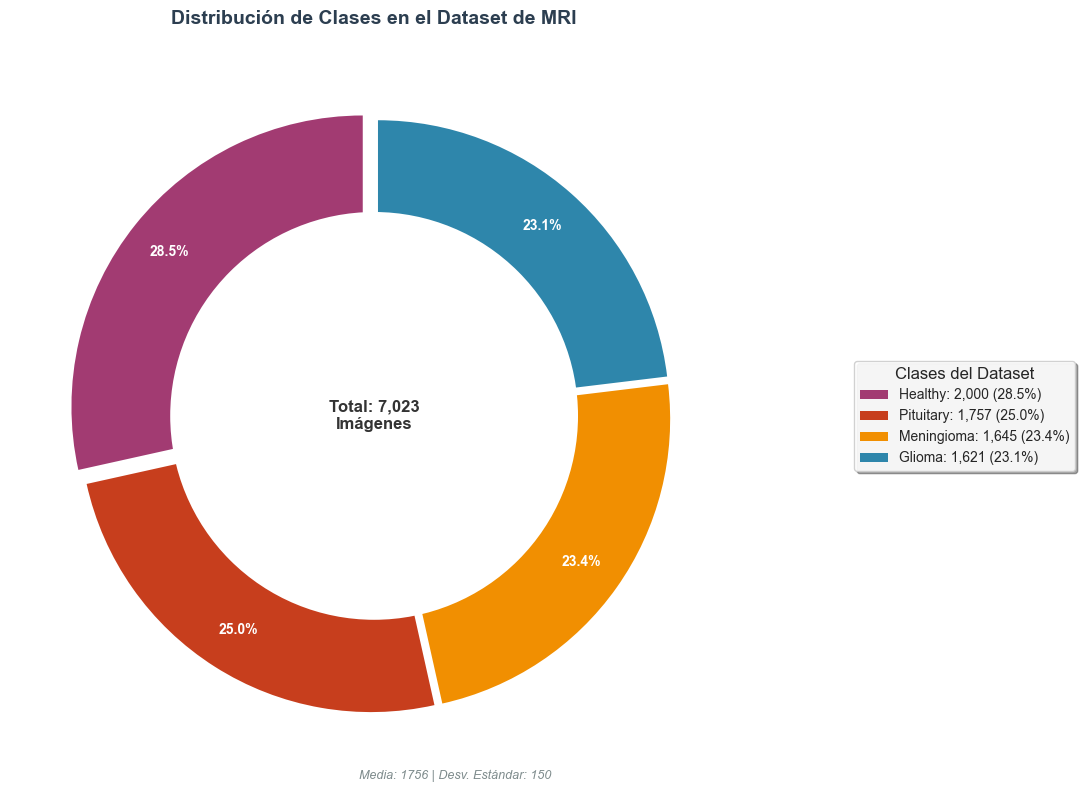

In [13]:
# Encontrar la carpeta principal del dataset
dataset_path = path
# Buscar la carpeta que contiene las clases
if os.path.exists(os.path.join(path, 'Training')):
    dataset_path = os.path.join(path, 'Training')
elif os.path.exists(os.path.join(path, 'training')):
    dataset_path = os.path.join(path, 'training')

print(f"Cargando dataset desde: {dataset_path}")

# Cargar dataset completo
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

# Mostrar información del dataset
print(f"\nTotal de imágenes: {len(full_dataset)}")
print(f"Número de clases: {len(full_dataset.classes)}")
print(f"Clases: {full_dataset.classes}")

# Visualizar distribución de clases
class_counts = {}
for idx, (path_img, label) in enumerate(full_dataset.samples):
    class_name = full_dataset.classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print("\nDistribución de clases:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} imágenes")

# Crear gráfica radial (pie chart) científica de la distribución de clases
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-v0_8-whitegrid')  # Estilo científico

# Preparar datos para el gráfico
labels = list(class_counts.keys())
sizes = list(class_counts.values())
total = sum(sizes)

# Colores científicos profesionales (esquema de colores tipo Nature/Science)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Azul, Morado, Naranja, Rojo oscuro

# Ordenar por tamaño para mejor visualización
sorted_data = sorted(zip(labels, sizes, colors), key=lambda x: x[1], reverse=True)
labels_sorted = [x[0] for x in sorted_data]
sizes_sorted = [x[1] for x in sorted_data]
colors_sorted = [x[2] for x in sorted_data]

# Calcular porcentajes
percentages = [(size/total)*100 for size in sizes_sorted]

# Crear gráfico de pastel con estilo científico
wedges, texts, autotexts = ax.pie(sizes_sorted, labels=None, colors=colors_sorted, 
                                   autopct=lambda pct: f'{pct:.1f}%',
                                   startangle=90, 
                                   textprops={'fontsize': 11, 'fontweight': 'bold', 'color': 'white'},
                                   pctdistance=0.85,
                                   explode=(0.05, 0.02, 0.02, 0.02))  # Separar ligeramente los segmentos

# Personalizar porcentajes con formato científico
for i, autotext in enumerate(autotexts):
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Agregar círculo en el centro para hacer un gráfico de dona (más científico)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
ax.add_artist(centre_circle)

# Agregar información estadística en el centro
total_text = f'Total: {total:,}\nImágenes'
ax.text(0, 0, total_text, ha='center', va='center', fontsize=12, 
        fontweight='bold', color='#333333')

# Agregar título científico
plt.title('Distribución de Clases en el Dataset de MRI', 
          fontsize=14, fontweight='bold', pad=20, color='#2c3e50')

# Crear tabla de datos en la leyenda (estilo científico)
legend_data = []
for label, size, pct in zip(labels_sorted, sizes_sorted, percentages):
    legend_data.append(f'{label.capitalize()}: {size:,} ({pct:.1f}%)')

# Leyenda científica con formato mejorado
ax.legend(wedges, legend_data, 
         title="Clases del Dataset",
         title_fontsize=12,
         fontsize=10,
         loc="center left", 
         bbox_to_anchor=(1.15, 0, 0.5, 1),
         frameon=True,
         fancybox=True,
         shadow=True,
         framealpha=0.9)

# Agregar anotaciones estadísticas
stats_text = f'Media: {total/len(sizes_sorted):.0f} | Desv. Estándar: {np.std(sizes_sorted):.0f}'
fig.text(0.5, 0.02, stats_text, ha='center', fontsize=9, 
         style='italic', color='#7f8c8d')

# Ajustar layout
plt.tight_layout()
plt.savefig('outputs/distribution_classes.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [14]:
# Dividir el dataset: 80% entrenamiento, 10% validación, 10% prueba
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Dividir usando random_split con semilla para reproducibilidad
generator = torch.Generator().manual_seed(42)
train_dataset_split, val_dataset_split, test_dataset_split = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=generator
)

# Obtener los índices de las divisiones
train_indices = train_dataset_split.indices
val_indices = val_dataset_split.indices
test_indices = test_dataset_split.indices

# Crear datasets con transformaciones específicas
# Para train usamos train_transform, para val y test usamos val_test_transform
train_dataset_full = datasets.ImageFolder(root=dataset_path, transform=train_transform)
val_test_dataset = datasets.ImageFolder(root=dataset_path, transform=val_test_transform)

# Crear Subset con las transformaciones correctas usando los mismos índices
from torch.utils.data import Subset

train_dataset_final = Subset(train_dataset_full, train_indices)
val_dataset_final = Subset(val_test_dataset, val_indices)
test_dataset_final = Subset(val_test_dataset, test_indices)

print(f"Entrenamiento: {len(train_dataset_final)} imágenes")
print(f"Validación: {len(val_dataset_final)} imágenes")
print(f"Prueba: {len(test_dataset_final)} imágenes")

# Crear DataLoaders (num_workers=0 para evitar problemas de multiprocessing en algunos sistemas)
# En macOS y Windows puede causar problemas, usar 0 es más seguro
train_loader = DataLoader(train_dataset_final, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset_final, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Entrenamiento: 5618 imágenes
Validación: 702 imágenes
Prueba: 703 imágenes


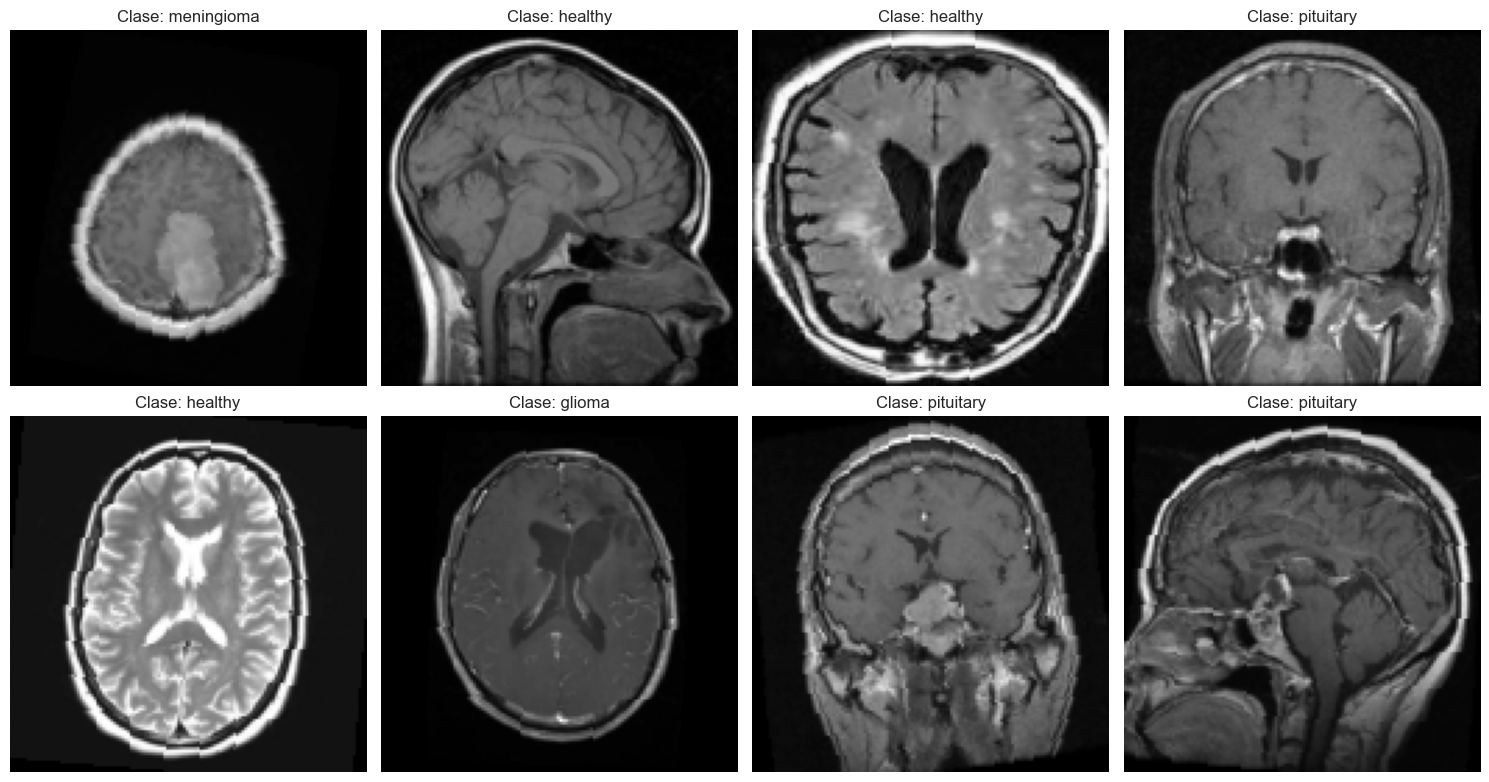

In [15]:
# Visualizar algunas imágenes del dataset
def visualize_samples(dataloader, class_names, num_samples=8):
    """Visualiza muestras aleatorias del dataset"""
    dataloader_iter = iter(dataloader)
    images, labels = next(dataloader_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].squeeze().numpy()
        # Denormalizar para visualización
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Clase: {class_names[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/samples_dataset.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(train_loader, full_dataset.classes)


## 4. Modelado

Implementaremos dos arquitecturas:
- **A. CNN desde cero:** Red sencilla con tres capas convolucionales y dos densas
- **B. Fine-tuning con ResNet18:** Modelo preentrenado con la capa de salida reemplazada


### 4.B. Fine-tuning con ResNet18

#### Adaptación de ResNet18 para Clasificación de Tumores Cerebrales

Se utiliza ResNet18 preentrenado en ImageNet como punto de partida para aprovechar el conocimiento aprendido en millones de imágenes. La arquitectura se adapta de dos maneras: (1) se modifica la primera capa convolucional para aceptar imágenes en escala de grises (1 canal en lugar de 3 canales RGB), y (2) se reemplaza la capa final de clasificación para que produzca 4 salidas correspondientes a nuestras clases. Se congelan todos los parámetros preentrenados excepto la primera y última capa, permitiendo que solo estas se adapten a nuestra tarea específica. Este enfoque de transfer learning requiere menos parámetros entrenables y potencialmente menos datos que entrenar desde cero.


### 4.A. CNN desde Cero


In [19]:
class BrainTumorCNN(nn.Module):
    """CNN simple con 3 capas convolucionales y 2 capas densas"""
    
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        
        # Primera capa convolucional
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Segunda capa convolucional
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Tercera capa convolucional
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Capas densas (fully connected)
        # Calcular el tamaño de salida después de las convoluciones
        # Input: 128x128, después de 3 MaxPool2d(2,2): 128/8 = 16x16
        # Así que: 128 * 16 * 16 = 32768
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Crear instancia del modelo
model_cnn = BrainTumorCNN(num_classes=4).to(device)
print("Modelo CNN creado:")
print(model_cnn)

# Contar parámetros
total_params = sum(p.numel() for p in model_cnn.parameters())
trainable_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"\nTotal de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")


Modelo CNN creado:
BrainTumorCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

Total de parámetros: 16,872,452
Parámetros entrenables: 16,872,452


### 4.B. Fine-tuning con ResNet18


In [21]:
# Cargar ResNet18 preentrenado
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# ResNet18 espera imágenes RGB (3 canales), pero nuestras imágenes son en escala de grises (1 canal)
# Modificamos la primera capa para aceptar 1 canal
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Congelar todos los parámetros
for param in model_resnet.parameters():
    param.requires_grad = False

# Reemplazar la capa final para nuestra tarea (4 clases)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 4)

# Hacer entrenables solo conv1 (modificada) y fc (nueva)
for param in model_resnet.conv1.parameters():
    param.requires_grad = True
for param in model_resnet.fc.parameters():
    param.requires_grad = True

# Mover al dispositivo
model_resnet = model_resnet.to(device)

print("Modelo ResNet18 configurado para fine-tuning")
print(f"Parámetros entrenables: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}")
print(f"Parámetros congelados: {sum(p.numel() for p in model_resnet.parameters() if not p.requires_grad):,}")


Modelo ResNet18 configurado para fine-tuning
Parámetros entrenables: 5,188
Parámetros congelados: 11,167,104


## 5. Entrenamiento y Validación

### 5.1. Definición de Funciones de Entrenamiento y Validación

Se implementan dos funciones clave: `train_epoch` y `validate`. La función `train_epoch` ejecuta una época completa de entrenamiento: realiza el forward pass calculando las predicciones y la pérdida, ejecuta el backward pass para calcular los gradientes, actualiza los parámetros del modelo mediante el optimizador, y calcula las métricas de pérdida y precisión durante el entrenamiento. La función `validate` evalúa el modelo en el conjunto de validación sin actualizar parámetros (modo evaluación), permitiendo monitorear el rendimiento del modelo en datos no vistos durante el entrenamiento.


In [23]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


### 5.2. Función Principal de Entrenamiento

Esta función coordina el proceso completo de entrenamiento durante múltiples épocas. Utiliza CrossEntropyLoss como función de pérdida y Adam como optimizador, configurado solo con los parámetros entrenables del modelo. Implementa un sistema de guardado automático basado en la pérdida de validación (early stopping): en cada época se guarda el modelo si la pérdida de validación mejora respecto a épocas anteriores. Al finalizar, carga automáticamente el mejor modelo entrenado. Además, incluye manejo de errores para interrupciones durante el entrenamiento.


In [25]:
def train_model(model, model_name, train_loader, val_loader, num_epochs, learning_rate):
    """Función completa de entrenamiento"""
    criterion = nn.CrossEntropyLoss()
    
    # Filtrar solo los parámetros entrenables para el optimizer
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=learning_rate)
    
    # Historial para gráficas
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    best_model_path = f'models/best_{model_name}.pt'
    
    print(f"\n{'='*50}")
    print(f"Entrenando {model_name}")
    print(f"{'='*50}")
    
    try:
        for epoch in range(num_epochs):
            # Entrenamiento
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            
            # Validación
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            
            # Guardar histórico
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # Guardar mejor modelo
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Época {epoch+1}/{num_epochs} - Mejor modelo guardado!")
            
            # Imprimir progreso
            print(f"Época {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print()
        
        # Cargar mejor modelo al final
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Mejor modelo cargado (Val Loss: {best_val_loss:.4f})")
        
    except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido por el usuario")
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Cargado mejor modelo hasta ahora (Val Loss: {best_val_loss:.4f})")
    except Exception as e:
        print(f"\nError durante el entrenamiento: {e}")
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path, map_location=device))
            print(f"Cargado mejor modelo hasta ahora (Val Loss: {best_val_loss:.4f})")
        raise
    
    return history, model


### 5.3. Entrenamiento del Modelo CNN desde Cero

Se ejecuta el entrenamiento de la CNN personalizada durante el número de épocas especificado (20 épocas por defecto). El proceso de entrenamiento monitorea continuamente la pérdida y precisión tanto en entrenamiento como en validación, guardando automáticamente el modelo que presenta la menor pérdida de validación. Esto garantiza que se utilice el modelo con mejor capacidad de generalización, no necesariamente el de la última época.


### 5.4. Entrenamiento del Modelo ResNet18 con Fine-tuning

Se entrena el modelo ResNet18 adaptado mediante transfer learning. A pesar de que solo se entrenan 5,188 parámetros (la primera y última capa), el modelo puede aprovechar las características aprendidas previamente en ImageNet. Este enfoque generalmente converge más rápido que entrenar desde cero y puede lograr buen rendimiento con menos datos.


### 5.5. Visualización de Curvas de Aprendizaje

Se generan gráficos comparativos de las curvas de aprendizaje para ambos modelos. Las curvas de pérdida y precisión permiten visualizar el proceso de entrenamiento y detectar posibles problemas como sobreajuste (cuando la pérdida de validación aumenta mientras la de entrenamiento disminuye) o subajuste (cuando ambas curvas se mantienen altas). La comparación lado a lado facilita la evaluación del rendimiento relativo de ambas arquitecturas.


In [29]:
# Entrenar modelo CNN desde cero
history_cnn, model_cnn_trained = train_model(
    model_cnn, 
    'cnn_scratch',
    train_loader, 
    val_loader, 
    NUM_EPOCHS, 
    LEARNING_RATE
)



Entrenando cnn_scratch
Época 1/20 - Mejor modelo guardado!
Época 1/20
  Train Loss: 0.7392, Train Acc: 71.11%
  Val Loss: 0.4400, Val Acc: 84.05%

Época 2/20 - Mejor modelo guardado!
Época 2/20
  Train Loss: 0.4408, Train Acc: 83.04%
  Val Loss: 0.3506, Val Acc: 87.04%

Época 3/20 - Mejor modelo guardado!
Época 3/20
  Train Loss: 0.3464, Train Acc: 86.28%
  Val Loss: 0.2475, Val Acc: 90.74%

Época 4/20 - Mejor modelo guardado!
Época 4/20
  Train Loss: 0.2722, Train Acc: 90.07%
  Val Loss: 0.2041, Val Acc: 91.74%

Época 5/20 - Mejor modelo guardado!
Época 5/20
  Train Loss: 0.2151, Train Acc: 91.92%
  Val Loss: 0.1763, Val Acc: 93.59%

Época 6/20 - Mejor modelo guardado!
Época 6/20
  Train Loss: 0.1699, Train Acc: 93.72%
  Val Loss: 0.1662, Val Acc: 93.73%

Época 7/20 - Mejor modelo guardado!
Época 7/20
  Train Loss: 0.1361, Train Acc: 95.21%
  Val Loss: 0.1116, Val Acc: 96.01%

Época 8/20
  Train Loss: 0.1133, Train Acc: 96.21%
  Val Loss: 0.1395, Val Acc: 96.01%

Época 9/20 - Mejor m

In [30]:
# Entrenar modelo ResNet18 con fine-tuning
history_resnet, model_resnet_trained = train_model(
    model_resnet,
    'resnet18',
    train_loader,
    val_loader,
    NUM_EPOCHS,
    LEARNING_RATE
)



Entrenando resnet18
Época 1/20 - Mejor modelo guardado!
Época 1/20
  Train Loss: 0.7487, Train Acc: 70.95%
  Val Loss: 0.7809, Val Acc: 71.65%

Época 2/20
  Train Loss: 0.5430, Train Acc: 79.35%
  Val Loss: 0.8252, Val Acc: 68.66%

Época 3/20 - Mejor modelo guardado!
Época 3/20
  Train Loss: 0.4536, Train Acc: 82.72%
  Val Loss: 0.4635, Val Acc: 82.91%

Época 4/20
  Train Loss: 0.4424, Train Acc: 83.13%
  Val Loss: 0.5788, Val Acc: 79.91%

Época 5/20
  Train Loss: 0.3933, Train Acc: 85.39%
  Val Loss: 0.4767, Val Acc: 81.34%

Época 6/20 - Mejor modelo guardado!
Época 6/20
  Train Loss: 0.3863, Train Acc: 85.48%
  Val Loss: 0.3712, Val Acc: 86.18%

Época 7/20
  Train Loss: 0.3638, Train Acc: 86.67%
  Val Loss: 0.4793, Val Acc: 81.77%

Época 8/20
  Train Loss: 0.3633, Train Acc: 86.53%
  Val Loss: 0.4067, Val Acc: 85.75%

Época 9/20
  Train Loss: 0.3302, Train Acc: 88.02%
  Val Loss: 0.3945, Val Acc: 86.18%

Época 10/20 - Mejor modelo guardado!
Época 10/20
  Train Loss: 0.3279, Train Ac

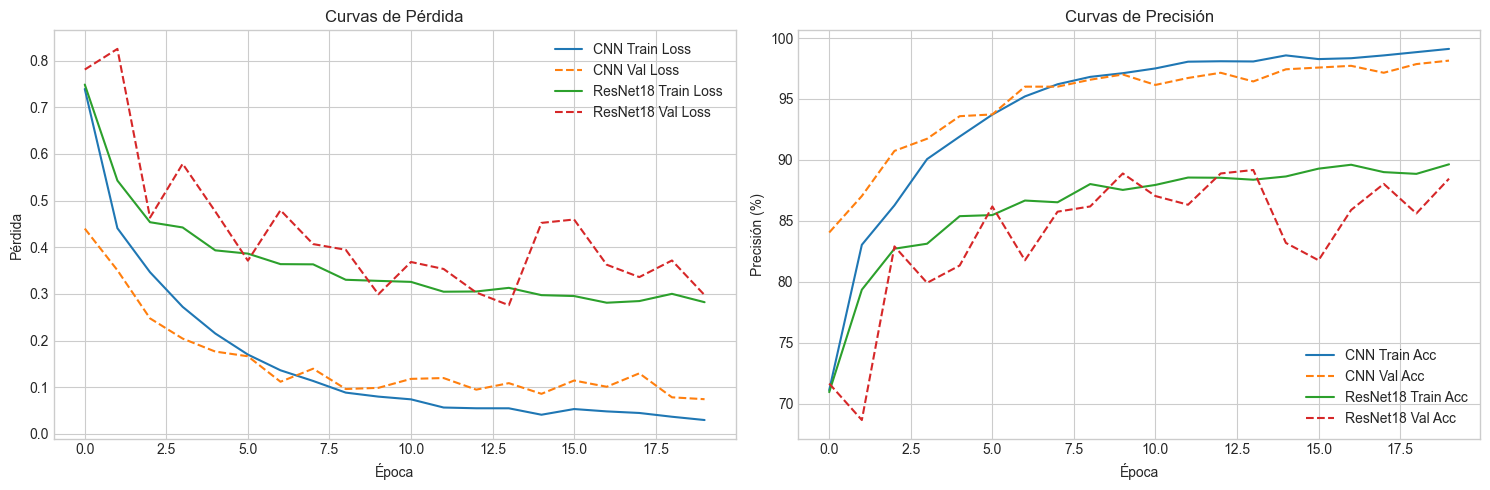

In [31]:
# Visualizar curvas de entrenamiento para ambos modelos
# Verificar que las historias existan antes de graficar
if 'history_cnn' in globals() and 'history_resnet' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Pérdida
    axes[0].plot(history_cnn['train_loss'], label='CNN Train Loss', linestyle='-')
    axes[0].plot(history_cnn['val_loss'], label='CNN Val Loss', linestyle='--')
    axes[0].plot(history_resnet['train_loss'], label='ResNet18 Train Loss', linestyle='-')
    axes[0].plot(history_resnet['val_loss'], label='ResNet18 Val Loss', linestyle='--')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Pérdida')
    axes[0].set_title('Curvas de Pérdida')
    axes[0].legend()
    axes[0].grid(True)

    # Precisión
    axes[1].plot(history_cnn['train_acc'], label='CNN Train Acc', linestyle='-')
    axes[1].plot(history_cnn['val_acc'], label='CNN Val Acc', linestyle='--')
    axes[1].plot(history_resnet['train_acc'], label='ResNet18 Train Acc', linestyle='-')
    axes[1].plot(history_resnet['val_acc'], label='ResNet18 Val Acc', linestyle='--')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Precisión (%)')
    axes[1].set_title('Curvas de Precisión')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('outputs/curves_loss_acc.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Advertencia: Las historias de entrenamiento no están disponibles. Ejecuta primero las celdas de entrenamiento.")


## 6. Evaluación del Modelo

### 6.1. Función de Evaluación Comprehensiva

Se implementa una función de evaluación completa que calcula múltiples métricas sobre el conjunto de prueba. La función realiza las predicciones del modelo sin calcular gradientes (modo evaluación), calcula la precisión global del modelo, genera una matriz de confusión que muestra los patrones de clasificación correcta e incorrecta entre clases, y genera un reporte detallado de clasificación que incluye precision, recall y F1-score por clase. Todos los resultados se guardan en archivos para análisis posterior.


In [33]:
def evaluate_model(model, test_loader, class_names, model_name, device):
    """Evalúa el modelo en el conjunto de prueba"""
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"\n{'='*50}")
    print(f"Evaluación de {model_name}")
    print(f"{'='*50}")
    print(f"Precisión en test: {accuracy:.2f}%")
    
    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()
    plt.savefig(f'outputs/confusion_matrix_{model_name.lower().replace(" ", "_")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    # Reporte de clasificación
    report = classification_report(all_labels, all_preds, 
                                   target_names=class_names,
                                   output_dict=True)
    
    # Guardar reporte como CSV
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f'outputs/classification_report_{model_name.lower().replace(" ", "_")}.csv')
    
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return accuracy, cm, report, all_preds, all_labels


### 6.2. Evaluación del Modelo ResNet18

Se evalúa el modelo ResNet18 entrenado en el conjunto de prueba. Esta evaluación proporciona una medida objetiva del rendimiento del modelo en datos completamente nuevos, no utilizados durante el entrenamiento ni la validación. La matriz de confusión revela qué clases el modelo confunde más frecuentemente, mientras que el reporte de clasificación proporciona métricas detalladas por clase.


### 6.3. Evaluación del Modelo CNN desde Cero

Se evalúa el modelo CNN personalizado entrenado desde cero en el mismo conjunto de prueba. Esta evaluación permite comparar directamente el rendimiento de ambas arquitecturas bajo las mismas condiciones, proporcionando insights sobre las ventajas y desventajas de cada enfoque (transfer learning vs. entrenamiento desde cero).



Evaluación de ResNet18
Precisión en test: 89.62%


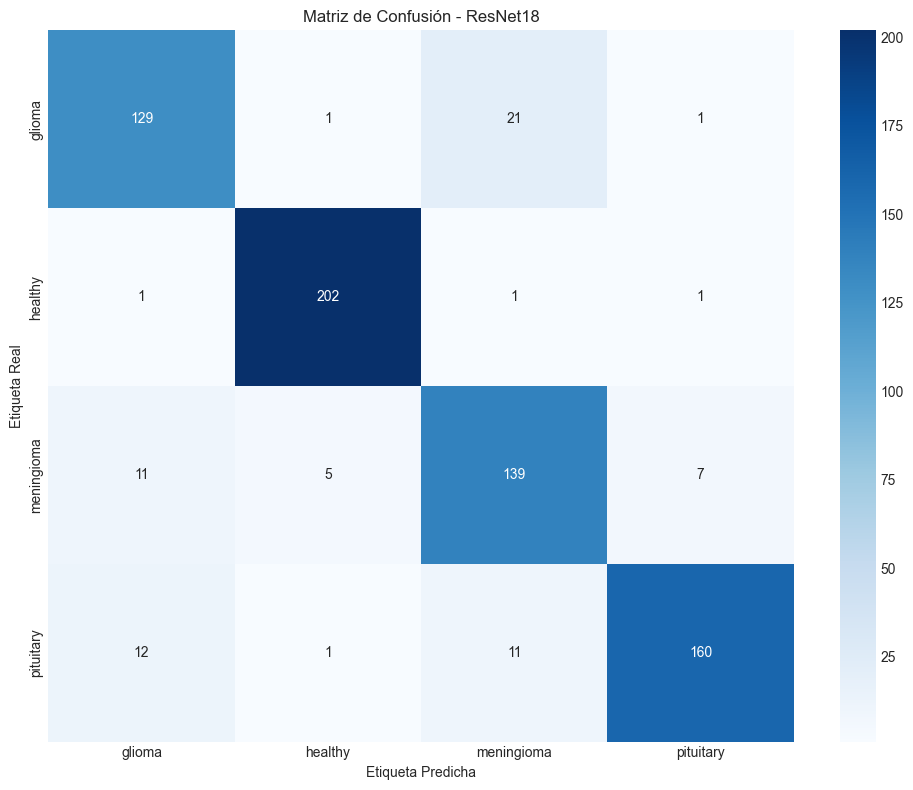


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       0.84      0.85      0.85       152
     healthy       0.97      0.99      0.98       205
  meningioma       0.81      0.86      0.83       162
   pituitary       0.95      0.87      0.91       184

    accuracy                           0.90       703
   macro avg       0.89      0.89      0.89       703
weighted avg       0.90      0.90      0.90       703



In [36]:
# Evaluar modelo ResNet18 (mejor modelo)
accuracy_resnet, cm_resnet, report_resnet, preds_resnet, labels_resnet = evaluate_model(
    model_resnet_trained,
    test_loader,
    full_dataset.classes,
    'ResNet18',
    device
)



Evaluación de CNN desde cero
Precisión en test: 98.15%


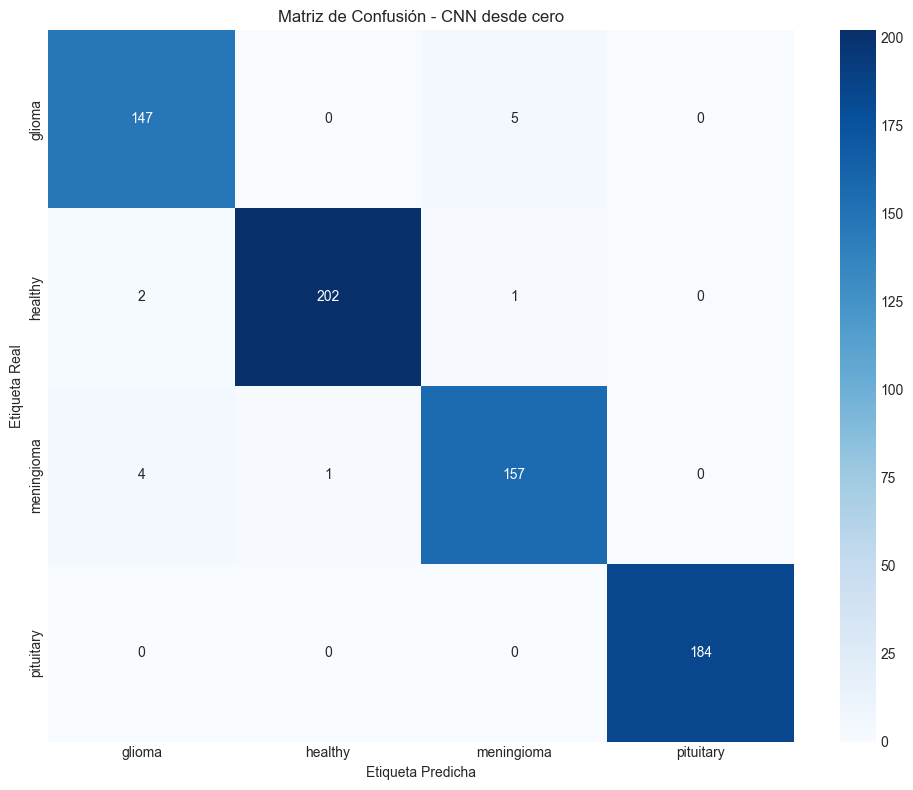


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       0.96      0.97      0.96       152
     healthy       1.00      0.99      0.99       205
  meningioma       0.96      0.97      0.97       162
   pituitary       1.00      1.00      1.00       184

    accuracy                           0.98       703
   macro avg       0.98      0.98      0.98       703
weighted avg       0.98      0.98      0.98       703



In [37]:
# Evaluar modelo CNN desde cero
accuracy_cnn, cm_cnn, report_cnn, preds_cnn, labels_cnn = evaluate_model(
    model_cnn_trained,
    test_loader,
    full_dataset.classes,
    'CNN desde cero',
    device
)


### 6.4. Visualización de Predicciones de Muestra

Se visualiza un conjunto de muestras aleatorias del conjunto de prueba con sus etiquetas verdaderas y predichas, junto con la confianza del modelo para cada predicción. Las predicciones correctas se muestran en verde y las incorrectas en rojo, facilitando la identificación visual de los errores del modelo. Esta visualización permite una comprensión cualitativa del rendimiento del modelo más allá de las métricas numéricas.


### 6.5. Comparación Final de Modelos

Se genera una tabla comparativa que resume el rendimiento de ambos modelos en términos de precisión en el conjunto de prueba, precisión y pérdida final en entrenamiento y validación. Esta comparación permite una evaluación objetiva de las ventajas y desventajas de cada arquitectura y ayuda a decidir qué modelo utilizar en aplicaciones prácticas. Los resultados se guardan en formato CSV para análisis posterior.


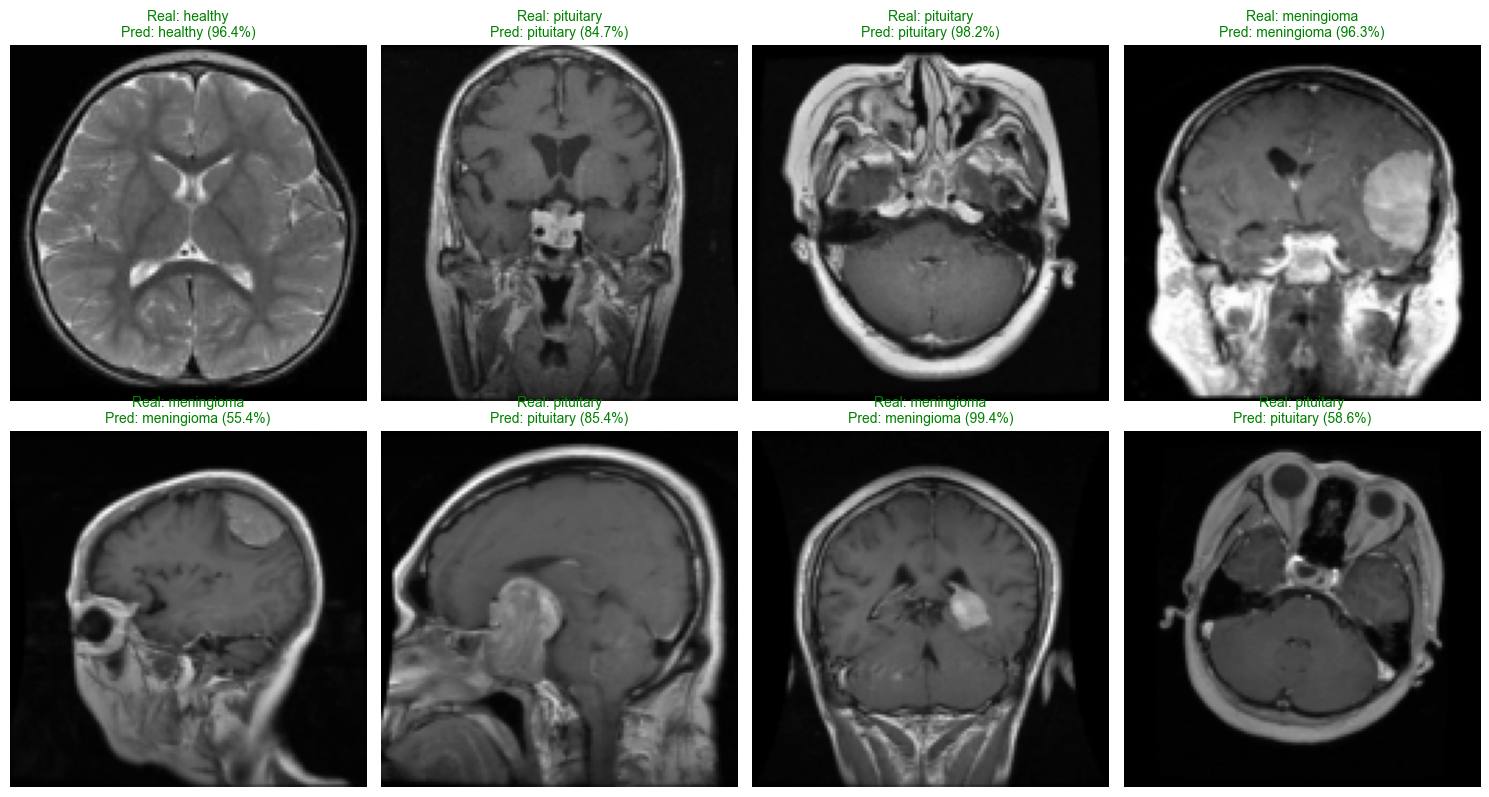

In [40]:
# Visualizar predicciones de muestra
def visualize_predictions(model, test_loader, class_names, num_samples=8, device=device):
    """Visualiza predicciones del modelo en muestras del conjunto de prueba"""
    model.eval()
    
    # Obtener un batch de datos
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Hacer predicciones
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # Visualizar
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu().squeeze().numpy()
        # Denormalizar
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img, cmap='gray')
        
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        confidence = probabilities[i][predicted[i]].item() * 100
        
        color = 'green' if predicted[i] == labels[i] else 'red'
        axes[i].set_title(f'Real: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('outputs/samples_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualizar predicciones del mejor modelo (ResNet18)
visualize_predictions(model_resnet_trained, test_loader, full_dataset.classes)


In [41]:
# Comparación final de modelos
# Verificar que las variables existan antes de comparar
if all(var in globals() for var in ['accuracy_cnn', 'accuracy_resnet', 'history_cnn', 'history_resnet']):
    comparison_df = pd.DataFrame({
        'Modelo': ['CNN desde cero', 'ResNet18 (Fine-tuning)'],
        'Precisión Test (%)': [accuracy_cnn, accuracy_resnet],
        'Train Acc Final (%)': [history_cnn['train_acc'][-1], history_resnet['train_acc'][-1]],
        'Val Acc Final (%)': [history_cnn['val_acc'][-1], history_resnet['val_acc'][-1]],
        'Train Loss Final': [history_cnn['train_loss'][-1], history_resnet['train_loss'][-1]],
        'Val Loss Final': [history_cnn['val_loss'][-1], history_resnet['val_loss'][-1]]
    })

    print("\n" + "="*70)
    print("COMPARACIÓN DE MODELOS")
    print("="*70)
    print(comparison_df.to_string(index=False))
    print("="*70)

    # Guardar comparación
    comparison_df.to_csv('outputs/model_comparison.csv', index=False)
else:
    print("Advertencia: No todas las variables necesarias están disponibles. Ejecuta primero las celdas de evaluación.")



COMPARACIÓN DE MODELOS
                Modelo  Precisión Test (%)  Train Acc Final (%)  Val Acc Final (%)  Train Loss Final  Val Loss Final
        CNN desde cero           98.150782            99.110004          98.148148          0.029529        0.074184
ResNet18 (Fine-tuning)           89.615932            89.640441          88.461538          0.282138        0.297398


### Tabla de Comparación de Modelos

A continuación se presenta una tabla comparativa con las métricas de rendimiento de ambos modelos entrenados.


In [43]:
# Mostrar tabla de comparación de modelos guardada
import os
from IPython.display import display, HTML

# Intentar cargar la tabla guardada
comparison_file = 'outputs/model_comparison.csv'

if os.path.exists(comparison_file):
    # Cargar tabla desde CSV
    comparison_table = pd.read_csv(comparison_file)
    
    # Formatear la tabla para mejor visualización
    print("\n" + "="*80)
    print("TABLA COMPARATIVA DE MODELOS - MÉTRICAS DE RENDIMIENTO")
    print("="*80)
    print()
    
    # Mostrar tabla formateada
    display(comparison_table.style.format({
        'Precisión Test (%)': '{:.2f}%',
        'Train Acc Final (%)': '{:.2f}%',
        'Val Acc Final (%)': '{:.2f}%',
        'Train Loss Final': '{:.4f}',
        'Val Loss Final': '{:.4f}'
    }).set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#2E86AB'),
                                          ('color', 'white'),
                                          ('font-weight', 'bold'),
                                          ('text-align', 'center'),
                                          ('padding', '10px')]},
        {'selector': 'tbody td', 'props': [('text-align', 'center'),
                                          ('padding', '8px')]},
        {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
        {'selector': 'tbody tr:hover', 'props': [('background-color', '#e8f4f8')]}
    ]).set_caption('Comparación de Rendimiento entre Modelos'))
    
    # También mostrar en formato texto para referencia
    print("\n" + "-"*80)
    print("RESUMEN COMPARATIVO:")
    print("-"*80)
    for idx, row in comparison_table.iterrows():
        print(f"\n{row['Modelo']}:")
        print(f"  • Precisión en Test: {row['Precisión Test (%)']:.2f}%")
        print(f"  • Precisión en Entrenamiento: {row['Train Acc Final (%)']:.2f}%")
        print(f"  • Precisión en Validación: {row['Val Acc Final (%)']:.2f}%")
        print(f"  • Pérdida en Entrenamiento: {row['Train Loss Final']:.4f}")
        print(f"  • Pérdida en Validación: {row['Val Loss Final']:.4f}")
    
    print("\n" + "="*80)
    
else:
    # Si no existe el archivo, intentar construir la tabla desde las variables disponibles
    if all(var in globals() for var in ['accuracy_cnn', 'accuracy_resnet', 'history_cnn', 'history_resnet']):
        comparison_table = pd.DataFrame({
            'Modelo': ['CNN desde cero', 'ResNet18 (Fine-tuning)'],
            'Precisión Test (%)': [accuracy_cnn, accuracy_resnet],
            'Train Acc Final (%)': [history_cnn['train_acc'][-1], history_resnet['train_acc'][-1]],
            'Val Acc Final (%)': [history_cnn['val_acc'][-1], history_resnet['val_acc'][-1]],
            'Train Loss Final': [history_cnn['train_loss'][-1], history_resnet['train_loss'][-1]],
            'Val Loss Final': [history_cnn['val_loss'][-1], history_resnet['val_loss'][-1]]
        })
        
        print("\n" + "="*80)
        print("TABLA COMPARATIVA DE MODELOS - MÉTRICAS DE RENDIMIENTO")
        print("="*80)
        print()
        
        display(comparison_table.style.format({
            'Precisión Test (%)': '{:.2f}%',
            'Train Acc Final (%)': '{:.2f}%',
            'Val Acc Final (%)': '{:.2f}%',
            'Train Loss Final': '{:.4f}',
            'Val Loss Final': '{:.4f}'
        }).set_table_styles([
            {'selector': 'thead th', 'props': [('background-color', '#2E86AB'),
                                              ('color', 'white'),
                                              ('font-weight', 'bold'),
                                              ('text-align', 'center'),
                                              ('padding', '10px')]},
            {'selector': 'tbody td', 'props': [('text-align', 'center'),
                                              ('padding', '8px')]},
            {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
            {'selector': 'tbody tr:hover', 'props': [('background-color', '#e8f4f8')]}
        ]).set_caption('Comparación de Rendimiento entre Modelos'))
        
    else:
        print("⚠️ Advertencia: No se encontró el archivo de comparación ni las variables necesarias.")
        print("   Ejecuta primero las celdas de entrenamiento y evaluación para generar la tabla.")



TABLA COMPARATIVA DE MODELOS - MÉTRICAS DE RENDIMIENTO



,Modelo,Precisión Test (%),Train Acc Final (%),Val Acc Final (%),Train Loss Final,Val Loss Final
0,CNN desde cero,98.15%,99.11%,98.15%,0.0295,0.0742
1,ResNet18 (Fine-tuning),89.62%,89.64%,88.46%,0.2821,0.2974



--------------------------------------------------------------------------------
RESUMEN COMPARATIVO:
--------------------------------------------------------------------------------

CNN desde cero:
  • Precisión en Test: 98.15%
  • Precisión en Entrenamiento: 99.11%
  • Precisión en Validación: 98.15%
  • Pérdida en Entrenamiento: 0.0295
  • Pérdida en Validación: 0.0742

ResNet18 (Fine-tuning):
  • Precisión en Test: 89.62%
  • Precisión en Entrenamiento: 89.64%
  • Precisión en Validación: 88.46%
  • Pérdida en Entrenamiento: 0.2821
  • Pérdida en Validación: 0.2974



## 7. Resumen y Conclusiones

### Resultados Obtenidos

Se han entrenado y evaluado dos modelos para la clasificación de tumores cerebrales en imágenes MRI:

1. **CNN desde cero**: Arquitectura simple con 3 capas convolucionales y 2 capas densas
2. **ResNet18 con Fine-tuning**: Modelo preentrenado con la primera y última capa adaptadas

### Archivos Generados

Los siguientes archivos han sido guardados en las carpetas correspondientes:

- `models/best_cnn_scratch.pt`: Modelo CNN entrenado
- `models/best_resnet18.pt`: Modelo ResNet18 entrenado (mejor modelo)
- `outputs/curves_loss_acc.png`: Curvas de entrenamiento
- `outputs/confusion_matrix_*.png`: Matrices de confusión
- `outputs/classification_report_*.csv`: Reportes de clasificación
- `outputs/samples_predictions.png`: Visualización de predicciones
- `outputs/model_comparison.csv`: Comparación de modelos

### Notas Finales

- El modelo con mejor rendimiento se guarda automáticamente durante el entrenamiento
- Todos los gráficos y métricas están disponibles en la carpeta `outputs/`
- El dataset se descarga automáticamente usando KaggleHub
- El código es reproducible usando la semilla configurada (42)
